**<h3 style="text-align: center; color: #0066FF;">TRANSFORM DATA LOGIN </h3>**

### **1. Extract features**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df=pd.read_csv("../ingest_from_ITS/data/m952_login_2025-05-04_00-00-00_to_2025-06-19_00-00-00.csv",usecols=[
    "@timestamp", "user.id", 
    "event.its.properties.gold",
    "event.its.properties.diamond","event.its.properties.power_point","event.its.properties.level",
    "event.its.properties.vip_level","event.its.properties.dragon_gold"
    ]) 
df.shape

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Local\Temp\ipykernel_6948\3795368262.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../ingest_from_ITS/data/m952_login_2025-05-04_00-00-00_to_2025-06-19_00-00-00.csv",usecols=[


(18847399, 8)

In [3]:
df['user.id']=df['user.id'].astype(str)

In [ ]:
# pd.DataFrame(df['user.id'].unique(), columns=["user.id"]).to_csv("test.csv", index=False, header=True)

In [4]:
df=df[~df['user.id'].isnull()]
df.reset_index(drop=True,inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18847399 entries, 0 to 18847398
Data columns (total 8 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   @timestamp                        object
 1   user.id                           object
 2   event.its.properties.gold         int64 
 3   event.its.properties.diamond      int64 
 4   event.its.properties.power_point  int64 
 5   event.its.properties.level        int64 
 6   event.its.properties.vip_level    int64 
 7   event.its.properties.dragon_gold  int64 
dtypes: int64(6), object(2)
memory usage: 1.1+ GB


In [7]:
df.head(3)

,@timestamp,user.id,event.its.properties.gold,event.its.properties.diamond,event.its.properties.power_point,event.its.properties.level,event.its.properties.vip_level,event.its.properties.dragon_gold
0,2025-05-03T17:00:00.000Z,2503270843381850,966082,0,39322,20,0,15
1,2025-05-03T17:00:00.000Z,2503270845559905,705266,0,38785,20,0,15
2,2025-05-03T17:00:00.000Z,2504091158315676,6579460,370,2370242,51,3,445


In [8]:
df['@timestamp'] = pd.to_datetime(df['@timestamp'], errors='coerce', utc=True)

In [9]:
len(df['user.id'].unique())

199370

In [10]:
df=df.rename(columns={'user.id':'vopenid'})

#### **Visualize**

In [11]:
VS = False

In [10]:
cols_plot = [
    "event.its.properties.gold", "event.its.properties.diamond",
    "event.its.properties.power_point", "event.its.properties.dragon_gold"
]

if VS:
    for col in cols_plot:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

In [11]:
if VS:
    asset_cols = [
        "event.its.properties.gold",
        "event.its.properties.diamond",
        "event.its.properties.dragon_gold"
    ]
    df_corr = df[asset_cols].apply(pd.to_numeric, errors="coerce").corr()

    sns.heatmap(df_corr, annot=True, cmap="coolwarm")
    plt.xticks(rotation=45)
    plt.title("Correlation amongs resources")
    plt.show()

In [12]:
if VS:
    df["event.its.properties.power_point"] = pd.to_numeric(df["event.its.properties.power_point"], errors="coerce")
    df["event.its.properties.level"] = pd.to_numeric(df["event.its.properties.level"], errors="coerce")
    df["event.its.properties.vip_level"] = pd.to_numeric(df["event.its.properties.vip_level"], errors="coerce")

    df_scatter = df.dropna(subset=[
        "event.its.properties.power_point",
        "event.its.properties.level",
        "event.its.properties.vip_level"
    ])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_scatter,
        y="event.its.properties.power_point",
        x="event.its.properties.level",
        hue="event.its.properties.vip_level",
        palette="coolwarm",
        alpha=0.7,
        edgecolor=None
    )
    plt.title("Power Point vs Level (hue by VIP)")
    plt.xlabel("Level")
    plt.ylabel("Power Point")
    plt.legend(title="VIP Level", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

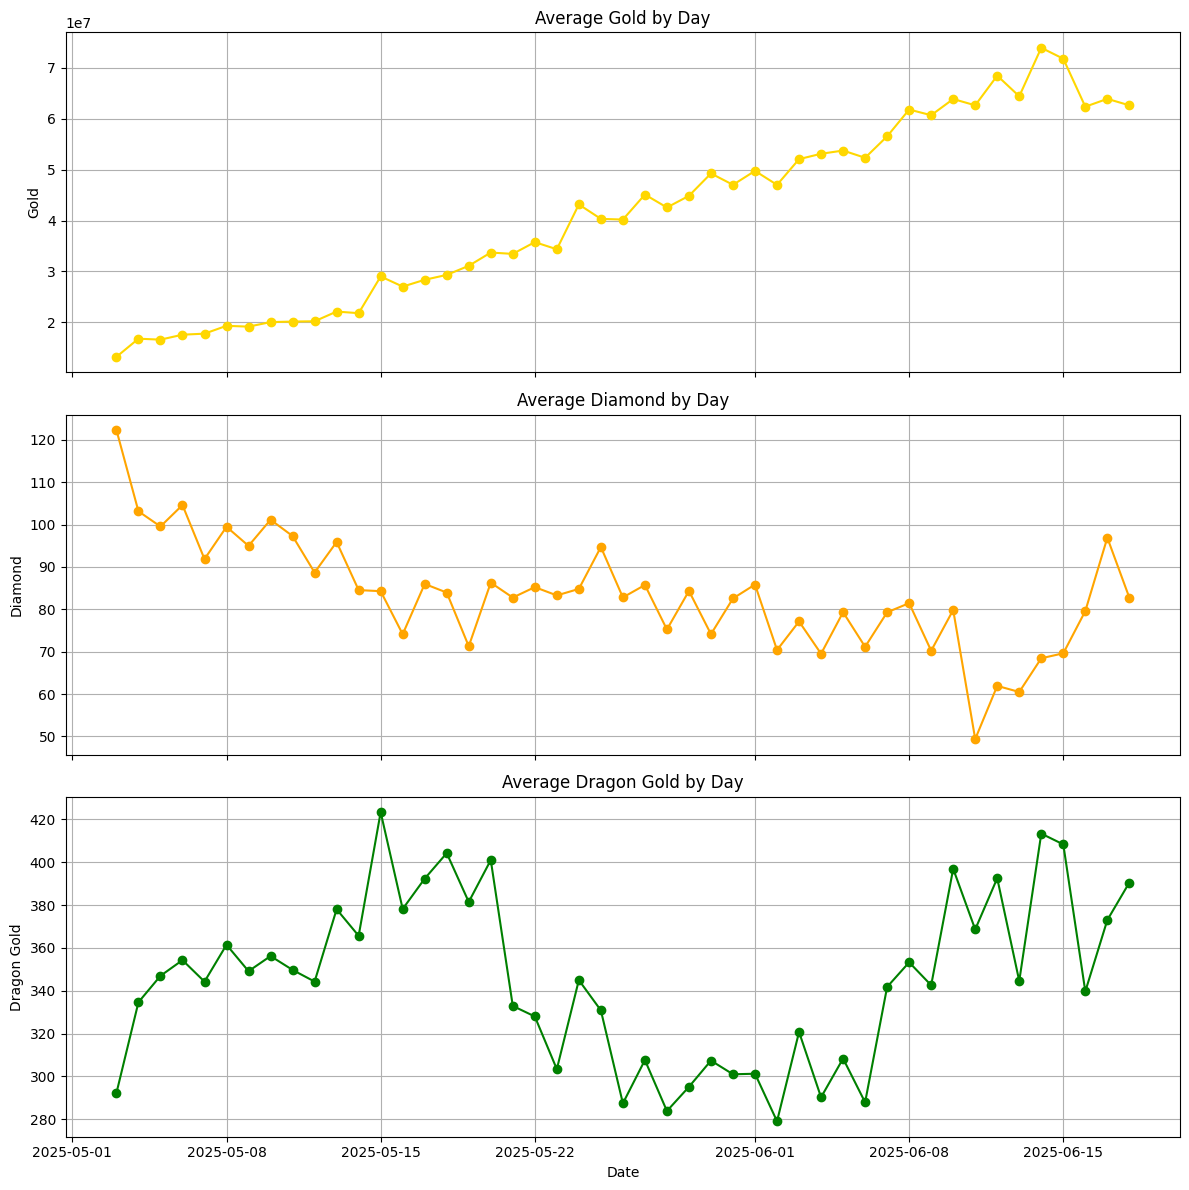

In [43]:
df["date"] = df["@timestamp"].dt.date
daily_assets = df.groupby("date")[[
    "event.its.properties.diamond",
    "event.its.properties.gold",
    "event.its.properties.dragon_gold"
]].mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

axes[0].plot(daily_assets.index, daily_assets["event.its.properties.gold"], color='gold', marker='o')
axes[0].set_ylabel("Gold")
axes[0].set_title("Average Gold by Day")
axes[0].grid(True)

axes[1].plot(daily_assets.index, daily_assets["event.its.properties.diamond"], color='orange', marker='o')
axes[1].set_ylabel("Diamond")
axes[1].set_title("Average Diamond by Day")
axes[1].grid(True)

axes[2].plot(daily_assets.index, daily_assets["event.its.properties.dragon_gold"], color='green', marker='o')
axes[2].set_ylabel("Dragon Gold")
axes[2].set_title("Average Dragon Gold by Day")
axes[2].set_xlabel("Date")
axes[2].grid(True)

plt.tight_layout()
plt.show()

#### **Create features**

In [21]:
now = pd.Timestamp("2025-06-16 12:00:00", tz="UTC")

In [22]:
df=df.sort_values(by=['@timestamp'])

In [23]:
df['@timestamp'].min(),df['@timestamp'].max()

(Timestamp('2025-05-03 17:00:00+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [24]:
data=df

In [25]:
# time update
def last_update_time(group):
    last_time = group['@timestamp'].max()
    return {
        'last_update_time': last_time
    }

In [26]:
# count how many days that user login
def num_day_login(group):
    num_day = group['@timestamp'].dt.date.nunique()
    return {
        "num_day_login":num_day,
    }

In [27]:
# count how many sessions that user login per day
def num_session_on_day_login(group):
    if group.empty:
        return {
            'avg_login_per_day': 0
        }
    group['date'] = group['@timestamp'].dt.date
    daily_counts = group.groupby('date').size()
    avg = daily_counts.mean()
    return {
        'avg_login_per_day': avg
    }

In [28]:
# calculate average time amongs logins of user
def avg_between_login(group):
    times = group['@timestamp'].sort_values()
    if len(times) < 2:
        return {
            'avg_between_login': 0
        }
    deltas = times.diff().dropna()
    res=deltas.mean().total_seconds() / 86400
    return {
        'avg_between_login': res
    }

In [29]:
# the longest streak day that user login
def streak_login(group):
    days = pd.to_datetime(group['@timestamp'].dt.date).sort_values().drop_duplicates()
    streak = 1
    max_streak=1
    for i in range(1, len(days)):
        if (days.iloc[i] - days.iloc[i-1]).days == 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1
    return {
        'streak_login': max_streak
    }

In [30]:
# how many days that user not login again
def last_since_from_login(group):
    last_time = group['@timestamp'].max()
    last_time = last_time.tz_localize('UTC') if last_time.tzinfo is None else last_time
    res=(now-last_time).days
    return {
        'last_since_from_login': res
    }

In [31]:
# the popular time that user login
def popular_time_login(group):
    hours = group['@timestamp'].dt.hour
    mode = hours.mode()
    res=mode.iloc[0] if not mode.empty else None
    return {
        'popular_time_login': res
    }

In [32]:
# std gold
def std_gold_login(group):
    gold_series = group.sort_values('@timestamp')['event.its.properties.gold']
    if len(gold_series) < 2:
        std_gold = 0.0  
    else:
        std_gold = gold_series.std()
    
    return {
        'gold_std_login': std_gold
    }

In [33]:
# std diamond
def std_diamond_login(group):
    diamond_series = group.sort_values('@timestamp')['event.its.properties.diamond']
    if len(diamond_series) < 2:
        std_diamond = 0.0  
    else:
        std_diamond = diamond_series.std()
    
    return {
        'diamond_std_login': std_diamond
    }

In [34]:
# std silkcoin
def std_silkcoin_login(group):
    silkcoin_series = group.sort_values('@timestamp')['event.its.properties.dragon_gold']
    if len(silkcoin_series) < 2:
        std_silkcoin = 0.0  
    else:
        std_silkcoin = silkcoin_series.std()
    
    return {
        'silkcoin_std_login': std_silkcoin
    }

In [35]:
# the last powerpoint of user
def last_login_powerpoint(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'powerpoint_last_login': latest['event.its.properties.power_point']
    }

In [36]:
# slope gold
def slope_gold_login(group):
    group_sorted = group.sort_values('@timestamp')
    gold_values = group_sorted['event.its.properties.gold'].values

    n = len(gold_values)
    if n < 2:
        return { 'gold_slope_login': 0.0 }

    x = np.arange(n)
    y = gold_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'gold_slope_login': slope
    }

In [37]:
# slope diamond
def slope_diamond_login(group):
    group_sorted = group.sort_values('@timestamp')
    diamond_values = group_sorted['event.its.properties.diamond'].values

    n = len(diamond_values)
    if n < 2:
        return { 'diamond_slope_login': 0.0 }

    x = np.arange(n)
    y = diamond_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'diamond_slope_login': slope
    }

In [38]:
# slope silkcoin
def slope_silkcoin_login(group):
    group_sorted = group.sort_values('@timestamp')
    silkcoin_values = group_sorted['event.its.properties.dragon_gold'].values

    n = len(silkcoin_values)
    if n < 2:
        return { 'silkcoin_slope_login': 0.0 }

    x = np.arange(n)
    y = silkcoin_values

    mean_x = x.mean()
    mean_y = y.mean()

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sum((x - mean_x) ** 2)

    slope = numerator / denominator if denominator != 0 else 0.0

    return {
        'silkcoin_slope_login': slope
    }

In [39]:
# level of user
def last_login_level(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'level_last_login': latest['event.its.properties.level']
    }

In [41]:
# vip of user
def last_login_vip(group):
    latest = group.sort_values('@timestamp', ascending=False).iloc[0]
    return {
        'vip_last_login': latest['event.its.properties.vip_level']
    }

In [42]:
features_function=[
   last_update_time,
   num_day_login,
   num_session_on_day_login,
   avg_between_login,
   streak_login,
   last_since_from_login,
   popular_time_login,
   std_gold_login,
   std_diamond_login,
   std_silkcoin_login,
   slope_gold_login,
   slope_diamond_login,
   slope_silkcoin_login,
   last_login_powerpoint,
   last_login_level,
   last_login_vip,
]

In [44]:
def extract_group_features(group):
    result={}
    for func in features_function:
        try:
            result.update(func(group))
        except Exception as e:
            print(f"Error at feature: {func}. Error: {e}")
    return pd.Series(result)

df_res = data.groupby('vopenid').progress_apply(extract_group_features).reset_index()
df_res

100%|██████████| 199370/199370 [08:14<00:00, 403.09it/s]


,vopenid,last_update_time,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login
0,2206111754266455,2025-05-08 11:08:20+00:00,2,1.00,1.02,2,39,10,12632.46,0.00,0.00,17865.00,0.00,0.00,29366,9,0
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1.00,0.00,1,21,5,0.00,0.00,0.00,0.00,0.00,0.00,25359,1,0
2,2206111808105074,2025-06-16 02:01:16+00:00,2,3.00,0.09,2,0,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,74275,21,0
3,2206111830413361,2025-06-18 00:44:14+00:00,46,3.54,0.28,35,-2,22,7316897.55,0.00,22.10,-96636.83,0.00,-0.17,212547,27,0
4,2206111904162575,2025-05-20 01:58:44+00:00,1,1.00,0.00,1,27,1,0.00,0.00,0.00,0.00,0.00,0.00,24938,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199365,lkeu,2025-06-18 06:40:34+00:00,2,1.00,5.95,1,-2,6,3558.87,0.00,0.00,5033.00,0.00,0.00,24218,3,0
199366,lknew,2025-06-12 04:50:52+00:00,2,2.00,4.97,1,4,3,4839.08,0.00,0.00,2800.00,0.00,0.00,479146,36,0
199367,tri3,2025-06-16 08:20:13+00:00,1,2.00,0.10,1,0,5,0.00,0.00,0.00,0.00,0.00,0.00,26467,1,0
199368,vtvinh,2025-06-17 07:10:48+00:00,3,3.00,0.75,2,-1,6,186669.67,0.00,0.00,52153.97,0.00,0.00,106968,23,0


In [45]:
df_res['vopenid'] = df_res['vopenid'].astype(str).str.strip()

In [46]:
df_res.to_csv("data/login_transform.csv",index=False,header=True)

In [47]:
df_res['vopenid'].nunique()

199370

In [48]:
df_res

,vopenid,last_update_time,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login
0,2206111754266455,2025-05-08 11:08:20+00:00,2,1.00,1.02,2,39,10,12632.46,0.00,0.00,17865.00,0.00,0.00,29366,9,0
1,2206111758351763,2025-05-26 05:07:07+00:00,1,1.00,0.00,1,21,5,0.00,0.00,0.00,0.00,0.00,0.00,25359,1,0
2,2206111808105074,2025-06-16 02:01:16+00:00,2,3.00,0.09,2,0,1,191511.83,0.41,0.00,61253.34,-0.14,0.00,74275,21,0
3,2206111830413361,2025-06-18 00:44:14+00:00,46,3.54,0.28,35,-2,22,7316897.55,0.00,22.10,-96636.83,0.00,-0.17,212547,27,0
4,2206111904162575,2025-05-20 01:58:44+00:00,1,1.00,0.00,1,27,1,0.00,0.00,0.00,0.00,0.00,0.00,24938,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199365,lkeu,2025-06-18 06:40:34+00:00,2,1.00,5.95,1,-2,6,3558.87,0.00,0.00,5033.00,0.00,0.00,24218,3,0
199366,lknew,2025-06-12 04:50:52+00:00,2,2.00,4.97,1,4,3,4839.08,0.00,0.00,2800.00,0.00,0.00,479146,36,0
199367,tri3,2025-06-16 08:20:13+00:00,1,2.00,0.10,1,0,5,0.00,0.00,0.00,0.00,0.00,0.00,26467,1,0
199368,vtvinh,2025-06-17 07:10:48+00:00,3,3.00,0.75,2,-1,6,186669.67,0.00,0.00,52153.97,0.00,0.00,106968,23,0


### **Features time-series**

In [ ]:
data=df

In [ ]:
data=data.dropna(how='any',axis=0)

In [ ]:
data

,@timestamp,event.action,event.its.properties.dragon_gold,event.its.properties.gold,event.its.properties.power_point,event.its.properties.level,event.its.properties.diamond,event.its.properties.vip_level,vopenid
0,2025-05-14 17:00:00+00:00,its_login,171.00,3752910,1425822,47,390.00,3,2504191703569743
1,2025-05-14 17:00:00+00:00,its_login,0.00,287350,36020,20,0.00,0,2505062131237087
2,2025-05-14 17:00:00+00:00,its_login,592.00,7324129,1489372,51,323.00,3,2504102040141995
3,2025-05-14 17:00:00+00:00,its_login,20.00,8923197,2588267,54,76.00,3,2504150234546192
4,2025-05-14 17:00:01+00:00,its_login,5.00,83995,479944,34,0.00,0,2504231932214970
...,...,...,...,...,...,...,...,...,...
7839471,2025-06-11 16:59:53+00:00,its_login,3.00,4278736,8519305,62,0.00,3,2504240202258061
7839472,2025-06-11 16:59:54+00:00,its_login,39.00,391117343,20983343,78,0.00,0,2407212129533808
7839473,2025-06-11 16:59:57+00:00,its_login,0.00,295600,35189,20,0.00,0,2506050157378467
7839474,2025-06-11 16:59:58+00:00,its_login,0.00,0,26312,1,0.00,0,2506112336590867


In [ ]:
rename_map = {
    "event.its.properties.gold": "gold",
    "event.its.properties.diamond": "diamond",
    "event.its.properties.level": "level",
    "event.its.properties.power_point": "power",
    "event.its.properties.vip_level": "vip"
}
rename_map = {k: v for k, v in rename_map.items() if k in data.columns}
data = data.rename(columns=rename_map)
data

,@timestamp,event.action,event.its.properties.dragon_gold,gold,power,level,diamond,vip,vopenid
0,2025-05-14 17:00:00+00:00,its_login,171.00,3752910,1425822,47,390.00,3,2504191703569743
1,2025-05-14 17:00:00+00:00,its_login,0.00,287350,36020,20,0.00,0,2505062131237087
2,2025-05-14 17:00:00+00:00,its_login,592.00,7324129,1489372,51,323.00,3,2504102040141995
3,2025-05-14 17:00:00+00:00,its_login,20.00,8923197,2588267,54,76.00,3,2504150234546192
4,2025-05-14 17:00:01+00:00,its_login,5.00,83995,479944,34,0.00,0,2504231932214970
...,...,...,...,...,...,...,...,...,...
7839471,2025-06-11 16:59:53+00:00,its_login,3.00,4278736,8519305,62,0.00,3,2504240202258061
7839472,2025-06-11 16:59:54+00:00,its_login,39.00,391117343,20983343,78,0.00,0,2407212129533808
7839473,2025-06-11 16:59:57+00:00,its_login,0.00,295600,35189,20,0.00,0,2506050157378467
7839474,2025-06-11 16:59:58+00:00,its_login,0.00,0,26312,1,0.00,0,2506112336590867


In [ ]:
data["vopenid"] = data["vopenid"].astype(str)

In [ ]:
for col in ["gold", "diamond", "power", "level", "vip"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7396769 entries, 0 to 7839475
Data columns (total 9 columns):
 #   Column                            Dtype              
---  ------                            -----              
 0   @timestamp                        datetime64[ns, UTC]
 1   event.action                      object             
 2   event.its.properties.dragon_gold  float64            
 3   gold                              float64            
 4   power                             int64              
 5   level                             int64              
 6   diamond                           float64            
 7   vip                               float64            
 8   vopenid                           object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(2)
memory usage: 564.3+ MB


In [ ]:
data["@timestamp"] = pd.to_datetime(data["@timestamp"])  
data["date"] = data["@timestamp"].dt.date 

feature_cols = ["gold", "diamond", "level", "power", "vip"]
daily = (
    data.groupby(["vopenid", "date"])[feature_cols]
    .mean()
    .reset_index()
)
daily

,vopenid,date,gold,diamond,level,power,vip
0,1000,2025-05-23,NaN,0.00,1105309683.00,1.00,NaN
1,1000,2025-05-29,NaN,0.00,1105309683.00,1.00,NaN
2,1000,2025-06-02,NaN,0.00,1105309683.00,1.00,NaN
3,1008,2025-05-23,NaN,3.00,1105309683.00,1.00,NaN
4,1008,2025-05-24,NaN,0.43,1105309683.00,1.67,3.00
...,...,...,...,...,...,...,...
1367027,chungminhde,2025-05-26,140154266.50,0.00,52.00,1575250.00,0.00
1367028,chungminhde,2025-05-27,150715331.50,0.00,52.50,1761977.50,0.00
1367029,chungminhde,2025-06-10,133582705.50,0.00,50.00,1404586.50,0.00
1367030,data1,2025-05-27,5232.00,0.00,4.00,30145.00,0.00


In [ ]:
pivot = daily.pivot(index="vopenid", columns="date", values=feature_cols)

In [ ]:
pivot.columns = [f"{feature}_{str(date)}" for feature, date in pivot.columns]

In [ ]:
pivot = pivot.dropna()
pivot

,gold_2025-05-14,gold_2025-05-15,gold_2025-05-16,gold_2025-05-17,gold_2025-05-18,gold_2025-05-19,gold_2025-05-20,gold_2025-05-21,gold_2025-05-22,gold_2025-05-23,gold_2025-05-24,gold_2025-05-25,gold_2025-05-26,gold_2025-05-27,gold_2025-05-28,gold_2025-05-29,gold_2025-05-30,gold_2025-05-31,gold_2025-06-01,gold_2025-06-02,gold_2025-06-03,gold_2025-06-04,gold_2025-06-05,gold_2025-06-07,gold_2025-06-08,gold_2025-06-09,gold_2025-06-10,gold_2025-06-11,diamond_2025-05-14,diamond_2025-05-15,diamond_2025-05-16,diamond_2025-05-17,diamond_2025-05-18,diamond_2025-05-19,diamond_2025-05-20,diamond_2025-05-21,diamond_2025-05-22,diamond_2025-05-23,diamond_2025-05-24,diamond_2025-05-25,diamond_2025-05-26,diamond_2025-05-27,diamond_2025-05-28,diamond_2025-05-29,diamond_2025-05-30,diamond_2025-05-31,diamond_2025-06-01,diamond_2025-06-02,diamond_2025-06-03,diamond_2025-06-04,diamond_2025-06-05,diamond_2025-06-07,diamond_2025-06-08,diamond_2025-06-09,diamond_2025-06-10,diamond_2025-06-11,level_2025-05-14,level_2025-05-15,level_2025-05-16,level_2025-05-17,level_2025-05-18,level_2025-05-19,level_2025-05-20,level_2025-05-21,level_2025-05-22,level_2025-05-23,level_2025-05-24,level_2025-05-25,level_2025-05-26,level_2025-05-27,level_2025-05-28,level_2025-05-29,level_2025-05-30,level_2025-05-31,level_2025-06-01,level_2025-06-02,level_2025-06-03,level_2025-06-04,level_2025-06-05,level_2025-06-07,level_2025-06-08,level_2025-06-09,level_2025-06-10,level_2025-06-11,power_2025-05-14,power_2025-05-15,power_2025-05-16,power_2025-05-17,power_2025-05-18,power_2025-05-19,power_2025-05-20,power_2025-05-21,power_2025-05-22,power_2025-05-23,power_2025-05-24,power_2025-05-25,power_2025-05-26,power_2025-05-27,power_2025-05-28,power_2025-05-29,power_2025-05-30,power_2025-05-31,power_2025-06-01,power_2025-06-02,power_2025-06-03,power_2025-06-04,power_2025-06-05,power_2025-06-07,power_2025-06-08,power_2025-06-09,power_2025-06-10,power_2025-06-11,vip_2025-05-14,vip_2025-05-15,vip_2025-05-16,vip_2025-05-17,vip_2025-05-18,vip_2025-05-19,vip_2025-05-20,vip_2025-05-21,vip_2025-05-22,vip_2025-05-23,vip_2025-05-24,vip_2025-05-25,vip_2025-05-26,vip_2025-05-27,vip_2025-05-28,vip_2025-05-29,vip_2025-05-30,vip_2025-05-31,vip_2025-06-01,vip_2025-06-02,vip_2025-06-03,vip_2025-06-04,vip_2025-06-05,vip_2025-06-07,vip_2025-06-08,vip_2025-06-09,vip_2025-06-10,vip_2025-06-11
vopenid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
